如果不对多项式特征
进行标准化，会发生什么事情？能用其他方法解决这个问题吗？

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))  # 去掉文件名，返回文件所在的目录路径
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(project_root)

from myfunc import train_ch3, train_epoch_ch3

In [81]:
# 生成数据集
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)  # 分配大量空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))  # (200, 1)  # std=1差不多生成的数据在【-2，2】范围内（见my-linear-regression）
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))  # (200, 20)

# 将常数项单独提取
constant_feature = poly_features[:, 0:1]
other_features = poly_features[:, 1:]

# mean = poly_features.mean(0, keepdims=True)
# # std = poly_features.std(0, keepdim=True)  # 分析，输出中有nan，是因为std为零或接近0
# std = poly_features.std(0, keepdims=True) + 1e-8  # 添加正则化项
# poly_features = (poly_features - mean) / std

# 对其他特征标准化
mean = other_features.mean(axis=0, keepdims=True)
std = other_features.std(axis=0, keepdims=True) + 1e-8
other_features = (other_features - mean) / std

# 合并回完整的特征
poly_features = np.hstack([constant_feature, other_features])

# for i in range(max_degree):
#     poly_features[:, i] /= math.gamma(i + 1)   # gamma(n) = (n-1)!
labels = np.dot(poly_features, true_w)  # 每一行（每个样本）的20个特征和true_w做点积，得到(200, 1)
labels += np.random.normal(scale=0.1, size=labels.shape)  # 为了命名统一，这里scale就是std的意思

poly_features[:2, :]

array([[ 1.        , -0.16437307, -0.75401609, -0.05233788, -0.38294661,
        -0.04567955, -0.25833327, -0.05370345, -0.20291179, -0.06158929,
        -0.17313119, -0.06659807, -0.15461425, -0.06922568, -0.14173077,
        -0.07034273, -0.13198914, -0.07061196, -0.12418202, -0.07045733],
       [ 1.        , -0.02974633, -0.75638894, -0.05214261, -0.38295067,
        -0.04567936, -0.25833328, -0.05370345, -0.20291179, -0.06158929,
        -0.17313119, -0.06659807, -0.15461425, -0.06922568, -0.14173077,
        -0.07034273, -0.13198914, -0.07061196, -0.12418202, -0.07045733]])

In [82]:
# 将NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
        torch.float32) for x in [true_w, features, poly_features, labels]]

features[:10], poly_features[:2, :], labels[:2]

(tensor([[-0.0781],
         [ 0.0550],
         [ 0.4698],
         [ 1.1010],
         [-0.1819],
         [-1.3395],
         [-0.4762],
         [ 1.1558],
         [-0.4084],
         [-0.3223]]),
 tensor([[ 1.0000, -0.1644, -0.7540, -0.0523, -0.3829, -0.0457, -0.2583, -0.0537,
          -0.2029, -0.0616, -0.1731, -0.0666, -0.1546, -0.0692, -0.1417, -0.0703,
          -0.1320, -0.0706, -0.1242, -0.0705],
         [ 1.0000, -0.0297, -0.7564, -0.0521, -0.3830, -0.0457, -0.2583, -0.0537,
          -0.2029, -0.0616, -0.1731, -0.0666, -0.1546, -0.0692, -0.1417, -0.0703,
          -0.1320, -0.0706, -0.1242, -0.0705]]),
 tensor([6.9050, 6.9697]))

In [59]:
# 对模型进行训练和测试

In [60]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [70]:
def train(train_features, test_features, train_labels, test_labels, lr=0.01, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))  # 多项式中包含了偏置项（第一个feature）
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs],
                            ylim=[1e-3, 1e2],
                            legend=['train', 'test'])  # 画图：train loss 和 test loss（每20epoch）
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    
    print('weight:', net[0].weight.data.numpy())

不进行标准化的结果：

weight: [[ 5.0003214  1.1580002 -3.4055388  5.6100063]]


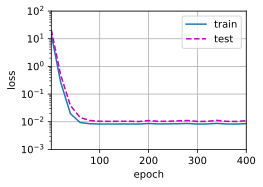

In [7]:
# 三阶多项式函数拟合（正常）
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[ 1.6021726 16.508863 ]]


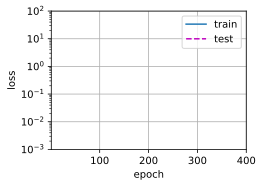

In [8]:
# 欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]]


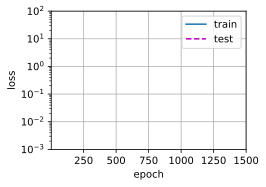

In [9]:
# 过拟合
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

使用其他标准化方式改进的尝试

In [ ]:
# mean = poly_features.mean(0, keepdim=True)
# # std = poly_features.std(0, keepdim=True)  # 分析，输出中有nan，是因为std为零或接近0
# std = poly_features.std(0, keepdim=True) + 1e-8  # 添加正则化项
# poly_features = (poly_features - mean) / std
# poly_features[:2, :]

tensor([[ 0.0000, -2.4483,  3.4875, -3.7632,  3.5195, -3.2870,  2.6207, -2.3129,
          1.6928, -1.4970,  1.0266, -0.9486,  0.6001, -0.6050,  0.3369, -0.3947,
          0.1764, -0.2669,  0.0790, -0.1894],
        [ 0.0000,  0.0719, -0.6635,  0.0213, -0.3198, -0.0225, -0.1957, -0.0486,
         -0.1361, -0.0606, -0.1058, -0.0660, -0.0899, -0.0684, -0.0813, -0.0695,
         -0.0767, -0.0701, -0.0741, -0.0704]])

weight: [[ 4.9906073  1.2264065 -3.3886676  5.590074 ]]


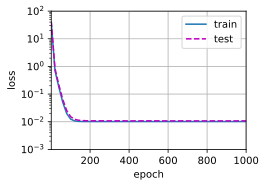

In [83]:
# 三阶多项式函数拟合（正常）
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:], lr=0.01, num_epochs=1000)  # 为什么第一个参数训练出来是这样的

weight: [[4.9128304 5.487045 ]]


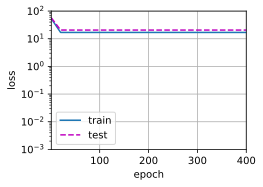

In [84]:
# 欠拟合
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 5.0004950e+00  1.9321394e+00 -3.0490887e+00  3.2783258e+00
  -6.8582225e-01  1.8378698e+00  8.2923025e-02  7.3224735e-01
   1.2631583e-01 -1.9473663e-03  6.2687986e-02 -2.3507343e-01
   7.4430838e-02 -2.1441981e-01 -4.6443418e-02 -1.7482524e-01
  -1.8177565e-02 -6.9680057e-02 -1.3538732e-01  5.2906170e-02]]


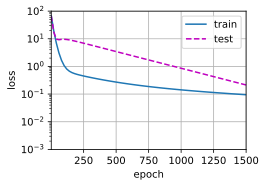

In [ ]:
# 过拟合
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], lr=0.001, num_epochs=1500)  # 减小学习率，不然会梯度爆炸